In [11]:
# LangGraph + LangChain (ChatOllama) implementation of the Desired Graph

from typing import TypedDict, Annotated, List, Dict, Any
from langgraph.graph import StateGraph, START, END, add_messages
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage
import pandas as pd
import json


In [32]:
# -----------------------------
# 1) Define State to carry everything needed
# -----------------------------
class State(TypedDict):
    messages: Annotated[List, add_messages]  # chat history, aggregated via add_messages
    structure: str                           
    objective: str                      
    testcases: str                            # input test case (row value from df["testcases"])
    review_summary: str                       

# -----------------------------
# 2) LLM initialization using ChatOllama
# -----------------------------
try:
    from langchain_ollama import ChatOllama  # preferred integration
except Exception:
    from langchain_community.chat_models import ChatOllama  # legacy fallback

# Choose an installed Ollama model (e.g., "llama3.1:8b", "mistral:7b", "qwen2.5")
llm = ChatOllama(
    model="llama3.1",  # <-- change to any model you've pulled with Ollama
    temperature=0
)

# -----------------------------
# 3) Node: eval_structure (single-arg: state)
# -----------------------------
def eval_structure(state: State) -> Dict[str, Any]:
    testcases = state.get("testcases", "")
    environment = state.get("env", {})

    system_message = """You are a Senior Software QA Architect. Your task is to evaluate the structure of a test case against the provided Acceptance Criteria. You will determine whether the acceptance criteria has been appropriately satisfied:
    Acceptance Criteria:
    - Test case steps follow a logical, sequential path that ensures reproducibility.
    - Actions are documented where data collection is required, and data collection is accurate and complete.
    - Steps are clear, concise, and free of jargon; absolutes are avoided.
    - Steps are numbered or ordered for easy execution.
    - Outcome aligns with the expected results.

    You will provide: assessment_verdict, assessment_rationale, identified_gaps, actionable_recommendations, and test_case_improvements. Propose improvements detecting misalignment between test case objective and actual steps.

    Response Format (produce exactly this JSON structure):
    {
    "assessment_verdict": "complete|partial|inadequate",
    "assessment_rationale": "<description of how and why the value for assessment_verdict was chosen>",
    "identified_gaps": ["<gap 1>", "<gap 2>", ...],
    "recommendations": ["<recommendation 1>", "<recommendation 2>", ...],
    "test_case_improvements": ["<improvement 1>", "<improvement 2>", ...]
    }
    """
    user_message = f"""Task: Evaluate the completeness of a test case against the acceptance criteria for Test Case Structure.
    Input Variables:
    - Test Case:
    {testcases}
    Produce output strictly in the Response Format JSON. Do not use Markdown.

    Now perform the review on the provided Input Variables and return only the Response Format JSON.
    """
    resp = llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content=user_message)
    ])

    ai_msg = AIMessage(content=resp.content, name="eval_structure")
    updates = {
        "messages": [ai_msg],
        "structure": resp.content,
    }
    return updates

# -----------------------------
# 4) Node: eval_objective (single-arg: state)
# -----------------------------
def eval_objective(state: State) -> Dict[str, Any]:
    testcases = state.get("testcases", "")
    environment = state.get("env", {})

    system_message = """You are a Senior Software QA Architect. Your task is to evaluate the completeness of a test case against the provided Acceptance Criteria. You will determine whether the acceptance criteria has been appropriately satisfied:
    Acceptance Criteria:
        - Test case includes all required components: unique ID, descriptive title, preconditions, input data, expected results, and detailed steps.
        - Test case objective is clear, specific, and aligned with the requirement.
        - Test case meets its intended objective (e.g., verifies actual outcome, not just UI interaction).
        - Both positive and negative scenarios are included.
        - Expected results align with the requirement and provide sufficient evidence for verification.
        - Completeness score should meet or exceed 80%.

    You will provide: assessment_verdict, assessment_rationale, identified_gaps, actionable_recommendations, and test_case_improvements. Propose improvements detecting misalignment between test case objective and actual steps.

    Response Format (produce exactly this JSON structure):
    {
        "assessment_verdict": "complete|partial|inadequate",
        "assessment_rationale": "<description of how and why the value for assessment_verdict was chosen>",
        "identified_gaps": ["<gap 1>", "<gap 2>", ...],
        "recommendations": ["<recommendation 1>", "<recommendation 2>", ...],
        "test_case_improvements": ["<improvement 1>", "<improvement 2>", ...]
    }
    """
    user_message = f"""
    Task: Evaluate the completeness of a test case against the acceptance criteria for Test Case Completeness.
    Input Variables:
    - Test Case:
    {testcases}

    Acceptance Criteria:
    - Test case includes all required components: unique ID, descriptive title, preconditions, input data, expected results, and detailed steps.
    - Test case objective is clear, specific, and aligned with the requirement.
    - Test case meets its intended objective (e.g., verifies actual outcome, not just UI interaction).
    - Both positive and negative scenarios are included.
    - Expected results align with the requirement and provide sufficient evidence for verification.
    - Completeness score should meet or exceed 80%.

    Produce output strictly in the Response Format JSON. Do not use Markdown.
    """
    resp = llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content=user_message)
    ])

    ai_msg = AIMessage(content=resp.content, name="eval_objective")
    updates = {
        "messages": [ai_msg],
        "objective": resp.content,
    }
    return updates

# -----------------------------
# 5) Node: get_review_summary (single-arg: state)
# -----------------------------
def get_review_summary(state: State) -> Dict[str, Any]:
    environment = state.get("env", {})

    all_messages_text = []
    for m in state.get("messages", []):
        content = getattr(m, "content", str(m))
        all_messages_text.append(content)

    system_message = """
    You are a Senior Test Verification Traceability Analyst with expertise in software quality assurance.
    You specialize in summarizing test case reviews, ensuring that critical improvements and recommendations are captured to provide a robust summary rationale.

    Response Format (produce exactly this JSON structure):

    {
        'testcase_review_summary': <summary of the outputs from test case review nodes>
    }
    """
    user_message = f"""
    Summarize the below test case review:

    ## Inputs
    Test Case Review: 
    {json.dumps(all_messages_text, ensure_ascii=False)}

    ## Notes 
    Produce output strictly in the described Response Format
    """
    resp = llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content=user_message)
    ])

    ai_msg = AIMessage(content=resp.content, name="get_review_summary")
    updates = {
        "messages": [ai_msg],
        "review_summary": resp.content
    }

    return updates

# -----------------------------
# 6) Build the graph (parallel fan-out + join)
# -----------------------------
graph = StateGraph(State)
graph.add_node("eval_structure", eval_structure)
graph.add_node("eval_objective", eval_objective)
graph.add_node("get_review_summary", get_review_summary)

graph.add_edge(START, "eval_structure")
graph.add_edge(START, "eval_objective")
graph.add_edge("eval_structure", "get_review_summary")
graph.add_edge("eval_objective", "get_review_summary")
graph.add_edge("get_review_summary", END)

workflow = graph.compile()

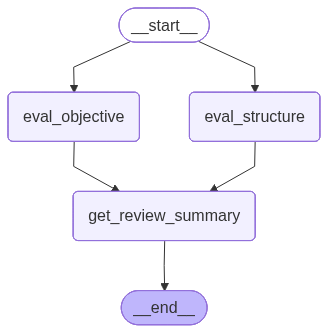

In [33]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(f"{e}")
    pass

In [45]:
tc_input ="""TC-001: Verify user login functionality
Title: User Login with Valid Credentials
Preconditions: User account exists and is active
Input Data: username='valid_user', password='valid_pass'
Steps:
1. Navigate to the login page.
2. Enter valid username.
3. Enter valid password.
4. Click 'Login'.
Expected Result: User is redirected to the dashboard; session is created; user name appears in header.
"""

initial_state: State = {
    "messages": [],
    "structure": "",
    "objective": "",
    "testcases": tc_input,    # <-- pass testcases via state
    "review_summary": ""
}

# Run workflow
final_state = workflow.invoke(initial_state)

In [55]:
print(final_state["review_summary"])

{
    'testcase_review_summary': "The test case review indicates that the test case is partially complete due to missing negative scenarios and unclear steps. Identified gaps include a lack of specificity in steps 2-4 regarding valid usernames and passwords, as well as insufficient expected results for verifying session creation. Recommendations include adding specific examples for usernames and passwords, modifying expected results to include assertions or validation statements, and rephrasing steps for clarity."
}
